In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
#pd.set_option("display.max_columns",50)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler
from sklearn.model_selection import cross_val_score,GridSearchCV,StratifiedKFold,RepeatedStratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score,auc,recall_score,precision_score,precision_recall_curve,confusion_matrix,\
plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve,classification_report,roc_auc_score,f1_score
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer,MissingIndicator,SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [8]:
import re
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="darkgrid") #white, dark, whitegrid, darkgrid, ticks


In [9]:
path = r"C:/Users/Krishna/Documents/kaggle/AV_HR_Hackathon"

In [10]:
train = pd.read_csv(f'{path}/input/train_jqd04QH.csv',dtype = {'enrollee_id':str})
test = pd.read_csv(f'{path}/input/test_KaymcHn.csv',dtype = {'enrollee_id':str})

f'train dimensions are : {train.shape}'
f'test dimensions are : {test.shape}'

train.head(2)
test.head(2)


'train dimensions are : (18359, 14)'

'test dimensions are : (15021, 13)'

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,16548,city_33,0.448,NaN,No relevent experience,Full time course,Graduate,STEM,<1,1000-4999,Public Sector,NaN,15
1,12036,city_28,0.939,Male,No relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,94


In [11]:
def data_info(df = train):
    df_info = pd.DataFrame(df.isna().sum(),columns = ['Null_count'])
    df_info['Non_Null_count'] = df_info.index.map(df.notna().sum())
    df_info['N_unique'] = df_info.index.map(df.nunique())
    df_info['D_types'] = df_info.index.map(df.dtypes)
    df_info['Blank_count'] = df_info.index.map((df=='').sum())
    return df_info

In [12]:
data_info(train)

,Null_count,Non_Null_count,N_unique,D_types,Blank_count
enrollee_id,0,18359,18359,object,0
city,0,18359,123,object,0
city_development_index,0,18359,93,float64,0
gender,4098,14261,3,object,0
relevent_experience,0,18359,2,object,0
enrolled_university,342,18017,3,object,0
education_level,457,17902,5,object,0
major_discipline,2838,15521,6,object,0
experience,59,18300,22,object,0
company_size,4779,13580,8,object,0


### checking event rate 

In [13]:
from collections import Counter
Counter(train.target)
train.target.value_counts(normalize=True) # works for numeric columns too with arguement `bins`
#train.city_development_index.value_counts(bins =6)

Counter({0: 15934, 1: 2425})

0    0.867912
1    0.132088
Name: target, dtype: float64

### treating null values

In [14]:
var = 'gender'
#f'count of NULLs in {var} : {train[[var]].isna().sum()[0]}'
train[var].value_counts(dropna = False,normalize = True)
pd.crosstab(index = train[var].fillna('Nan'), columns = train.target,margins = True,normalize='index',)

Male      0.701781
NaN       0.223215
Female    0.064709
Other     0.010295
Name: gender, dtype: float64

target,0,1
gender,,
Female,0.849327,0.150673
Male,0.877523,0.122477
Nan,0.844070,0.155930
Other,0.846561,0.153439
All,0.867912,0.132088


### creating NA indicator for all the columns containing NAs

In [15]:
mindicator = MissingIndicator(missing_values=np.nan,error_on_new=False)
z = mindicator.fit_transform(train.drop('target',axis = 1))

In [16]:
cols_na_ind = [x+'_na_ind' for x in train.columns[mindicator.features_]]
train = pd.concat([train,pd.DataFrame(1*z,columns = cols_na_ind)],axis = 1)
train.head(1)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,...,training_hours,target,gender_na_ind,enrolled_university_na_ind,education_level_na_ind,major_discipline_na_ind,experience_na_ind,company_size_na_ind,company_type_na_ind,last_new_job_na_ind
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,...,106,0,0,0,0,0,0,0,0,0


In [17]:
z = mindicator.transform(test)
cols_na_ind = [x+'_na_ind' for x in test.columns[mindicator.features_]]
test = pd.concat([test,pd.DataFrame(1*z,columns = cols_na_ind)],axis = 1)
test.head(1)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,...,last_new_job,training_hours,gender_na_ind,enrolled_university_na_ind,education_level_na_ind,major_discipline_na_ind,experience_na_ind,company_size_na_ind,company_type_na_ind,last_new_job_na_ind
0,16548,city_33,0.448,NaN,No relevent experience,Full time course,Graduate,STEM,<1,1000-4999,...,NaN,15,1,0,0,0,0,0,0,1


In [18]:
var = 'gender'
train[var].value_counts(dropna = False,normalize=True)
pd.crosstab(index = train[var].fillna('Nan'), columns = train.target,margins = True,normalize='index',)

Male      0.701781
NaN       0.223215
Female    0.064709
Other     0.010295
Name: gender, dtype: float64

target,0,1
gender,,
Female,0.849327,0.150673
Male,0.877523,0.122477
Nan,0.844070,0.155930
Other,0.846561,0.153439
All,0.867912,0.132088


In [19]:
var = 'enrolled_university'
train[var].value_counts(dropna = False,normalize=True)
pd.crosstab(index = train[var].fillna('Nan'), columns = train.target,margins = True,normalize='index',)

no_enrollment       0.743995
Full time course    0.173593
Part time course    0.063783
NaN                 0.018628
Name: enrolled_university, dtype: float64

target,0,1
enrolled_university,,
Full time course,0.809539,0.190461
Nan,0.836257,0.163743
Part time course,0.851409,0.148591
no_enrollment,0.883740,0.116260
All,0.867912,0.132088


In [20]:
var = 'education_level'
train[var].value_counts(dropna=False,normalize=True)
pd.crosstab(index = train[var].fillna('Nan'), columns = train.target,margins = True,normalize=True,dropna=False)

Graduate          0.586579
Masters           0.235252
High School       0.110681
Phd               0.025001
NaN               0.024892
Primary School    0.017594
Name: education_level, dtype: float64

target,0,1,All
education_level,,,
Graduate,0.503132,0.083447,0.586579
High School,0.097554,0.013127,0.110681
Masters,0.207310,0.027943,0.235252
Nan,0.021570,0.003323,0.024892
Phd,0.022114,0.002887,0.025001
Primary School,0.016232,0.001362,0.017594
All,0.867912,0.132088,1.000000


In [21]:
var = 'major_discipline'
train[var].value_counts(dropna=False,normalize=True)
pd.crosstab(index = train[var].fillna('Nan'), columns = train.target,margins = True,dropna = False,normalize='index')

STEM               0.748298
NaN                0.154584
Humanities         0.037475
Other              0.018683
Business Degree    0.016722
Arts               0.013018
No Major           0.011221
Name: major_discipline, dtype: float64

target,0,1
major_discipline,,
Arts,0.895397,0.104603
Business Degree,0.872964,0.127036
Humanities,0.864826,0.135174
Nan,0.882311,0.117689
No Major,0.902913,0.097087
Other,0.892128,0.107872
STEM,0.863372,0.136628
All,0.867912,0.132088


In [22]:
var = 'experience'
#train[var].value_counts(dropna=False,normalize=True)
pd.crosstab(index = train[var].fillna('Nan'), columns = train.target,margins = True,dropna = False,normalize='index',)

target,0,1
experience,,
1,0.761062,0.238938
10,0.875905,0.124095
11,0.875562,0.124438
12,0.895372,0.104628
13,0.883495,0.116505
14,0.875415,0.124585
15,0.889209,0.110791
16,0.896175,0.103825
17,0.902017,0.097983


In [23]:
na_cols = train.isna().sum()[train.isna().sum()>0].index
fillna_vals = dict(zip(na_cols,len(na_cols)*['missing']))
fillna_vals

{'gender': 'missing',
 'enrolled_university': 'missing',
 'education_level': 'missing',
 'major_discipline': 'missing',
 'experience': 'missing',
 'company_size': 'missing',
 'company_type': 'missing',
 'last_new_job': 'missing'}

In [24]:
train.fillna(fillna_vals,inplace = True)

test.fillna(fillna_vals,inplace = True)

In [25]:
data_info(train.loc[:,~train.columns.str.contains('_na_ind')])

,Null_count,Non_Null_count,N_unique,D_types,Blank_count
enrollee_id,0,18359,18359,object,0
city,0,18359,123,object,0
city_development_index,0,18359,93,float64,0
gender,0,18359,4,object,0
relevent_experience,0,18359,2,object,0
enrolled_university,0,18359,4,object,0
education_level,0,18359,6,object,0
major_discipline,0,18359,7,object,0
experience,0,18359,23,object,0
company_size,0,18359,9,object,0


In [26]:
train.to_csv(f'{path}/train_null_rem_1.csv',index= False)
test.to_csv(f'{path}/test_null_rem_1.csv',index= False)

<center><b> ***THE END** </center></b>

In [27]:
train['city_event_rate'] = train.city.map(train.groupby('city').target.mean())
test['city_event_rate'] = test.city.map(train.groupby('city').target.mean())

In [28]:
train['experience_rate'] = train.experience.map(train.groupby('experience').target.mean())
test['experience_rate'] = test.experience.map(train.groupby('experience').target.mean())

In [29]:
train['company_size_rate'] = train.company_size.map(train.groupby('company_size').target.mean())
test['company_size_rate'] = test.company_size.map(train.groupby('company_size').target.mean())

In [30]:
train['company_type_rate'] = train.company_type.map(train.groupby('company_type').target.mean())
test['company_type_rate'] = test.company_type.map(train.groupby('company_type').target.mean())

In [42]:
train['last_new_job_rate'] = train.last_new_job.map(train.groupby('last_new_job').target.mean())
test['last_new_job_rate'] = test.last_new_job.map(train.groupby('last_new_job').target.mean())

In [32]:
train['experience_le'] = pd.to_numeric(train.experience.replace({'<1': '0', '>20' : '29', 'missing' : 1.5}))
test['experience_le'] = pd.to_numeric(test.experience.replace({'<1': '0', '>20' : '29', 'missing' : 1.5}))
train['experience_le'].isna().sum()

0

In [33]:
edu_lev_dict = {'Primary School' : 1,'High School' : 2, 'Graduate' : 3, 'Masters' : 4, 'missing' :  5, 'Phd' : 6}

train['education_le'] = train.education_level.map(edu_lev_dict)
test['education_le'] = test.education_level.map(edu_lev_dict)
train['education_le'].isna().sum()

0

In [34]:
company_size_dict = {'<10' : 5, 
    '10/49' : 30,
        '50-99' : 75,
            '100-500' : 300,
                '500-999' : 750,
                    '1000-4999' : 3000,
                       '5000-9999' : 7500,
                        '10000+' : 30000,
                            'missing' : 5200}
#(5+30+75+300+750+3000+7500+30000)/8
train['company_size_le'] = train.company_size.map(company_size_dict)
test['company_size_le'] = test.company_size.map(company_size_dict)
train['company_size_le'].isna().sum()

0

In [35]:
train['stable'] = np.where(train.last_new_job.isin(['>4','3','4']),1,0)
test['stable'] = np.where(test.last_new_job.isin(['>4','3','4']),1,0)
train['stable'].value_counts()

0    12955
1     5404
Name: stable, dtype: int64

In [36]:
last_new_job_dict = {'>4' : 5,'4' : 4, '3' : 3, '2' : 2, '1' :  1, 'never' : 0, 'missing' : 2}

train['last_new_job_le'] = train.last_new_job.map(last_new_job_dict)
test['last_new_job_le'] = test.last_new_job.map(last_new_job_dict)
train['last_new_job_le'].isna().sum()

0

In [37]:
var = 'major_discipline'
temp = train[var].value_counts(normalize=True)
temp = pd.Series(temp[temp> 0.03].index)
#temp
train[var] = np.where(train[var].isin(temp), train[var],'low_pop')
train[var].value_counts(normalize=True)
test[var] = np.where(test[var].isin(temp), test[var],'low_pop')

STEM          0.748298
missing       0.154584
low_pop       0.059644
Humanities    0.037475
Name: major_discipline, dtype: float64

In [38]:
var = 'company_size'
temp = train[var].value_counts(normalize=True)
temp = pd.Series(temp[temp> 0.05].index)
#temp
train[var] = np.where(train[var].isin(temp), train[var],'low_pop')
train[var].value_counts(normalize=True)
test[var] = np.where(test[var].isin(temp), test[var],'low_pop')


missing      0.260308
50-99        0.169944
100-500      0.146958
10000+       0.111335
low_pop      0.081323
10/49        0.079852
1000-4999    0.076202
<10          0.074078
Name: company_size, dtype: float64

In [39]:
var = 'company_type'
temp = train[var].value_counts(normalize=True)
temp = pd.Series(temp[temp> 0.05].index)
#temp
train[var] = np.where(train[var].isin(temp), train[var],'low_pop')
train[var].value_counts(normalize=True)
test[var] = np.where(test[var].isin(temp), test[var],'low_pop')

Pvt Ltd           0.547470
missing           0.274470
low_pop           0.067269
Funded Startup    0.056539
Public Sector     0.054251
Name: company_type, dtype: float64

In [40]:
var = 'last_new_job'
temp = train[var].value_counts(normalize=True)
temp = pd.Series(temp[temp> 0.05].index)
#temp
train[var] = np.where(train[var].isin(temp), train[var],'low_pop')
train[var].value_counts(normalize=True)
test[var] = np.where(test[var].isin(temp), test[var],'low_pop')


1          0.412168
>4         0.181873
2          0.154420
never      0.119070
4          0.056539
3          0.055940
low_pop    0.019990
Name: last_new_job, dtype: float64

In [43]:
train.isna().sum()

enrollee_id                   0
city                          0
city_development_index        0
gender                        0
relevent_experience           0
enrolled_university           0
education_level               0
major_discipline              0
experience                    0
company_size                  0
company_type                  0
last_new_job                  0
training_hours                0
target                        0
gender_na_ind                 0
enrolled_university_na_ind    0
education_level_na_ind        0
major_discipline_na_ind       0
experience_na_ind             0
company_size_na_ind           0
company_type_na_ind           0
last_new_job_na_ind           0
city_event_rate               0
experience_rate               0
company_size_rate             0
company_type_rate             0
last_new_job_rate             0
experience_le                 0
education_le                  0
company_size_le               0
stable                        0
last_new

In [44]:
# 5 - DIct Vectorizer on train and transforming it on test
def dict_vec(train_set,cols,is_test, test_set):
    """
    returns dict vectorizer on train set or train & test set for chosen columns
    train_set: Dataset on which DV is to be fit
    cols: List of columns of train_set which are to be considered for DV
    is_test: Boolean, If DV is to be transformed on test too
    test_set: Test set on which DV is to be transformed
    """
    from sklearn.feature_extraction import DictVectorizer
    import pandas as pd
    dvec = DictVectorizer(sparse=False)
    if not is_test:
        train_dvec = dvec.fit_transform(train_set[cols].transpose().to_dict().values())
        train_dvec = pd.DataFrame(train_dvec, index = train_set.index, columns = dvec.get_feature_names())
        train_df = pd.concat([train_set.drop(cols, axis = 1),train_dvec], axis = 1)
        return train_df,pd.DataFrame(),dvec
    else:
        train_dvec = dvec.fit_transform(train_set[cols].transpose().to_dict().values())
        train_dvec = pd.DataFrame(train_dvec, index = train_set.index, columns = dvec.get_feature_names())
        train_df = pd.concat([train_set.drop(cols, axis = 1),train_dvec], axis = 1)
        test_dvec = dvec.transform(test_set[cols].transpose().to_dict().values())
        test_dvec = pd.DataFrame(test_dvec, index = test_set.index, columns = dvec.get_feature_names())
        test_df = pd.concat([test_set.drop(cols, axis = 1),test_dvec], axis = 1)
        return train_df, test_df,dvec

In [46]:
obj_cols = train.drop(['enrollee_id','city', 'experience'],axis = 1).select_dtypes('object').columns
#obj_cols = [x for x in train.columns if x != 'enrollee_id' or x != 'city']
obj_cols
sel_obj_cols = ['gender','relevent_experience','enrolled_university','major_discipline','company_type']
sel_obj_cols

Index(['gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'company_size', 'company_type',
       'last_new_job'],
      dtype='object')

['gender',
 'relevent_experience',
 'enrolled_university',
 'major_discipline',
 'company_type']

In [76]:
df_train,df_test,dv = dict_vec(train, obj_cols,is_test = True,test_set =test)

In [77]:
df_train.shape; df_test.shape
df_train.columns

(18359, 64)

(15021, 63)

Index(['enrollee_id', 'city', 'city_development_index', 'experience',
       'training_hours', 'target', 'gender_na_ind',
       'enrolled_university_na_ind', 'education_level_na_ind',
       'major_discipline_na_ind', 'experience_na_ind', 'company_size_na_ind',
       'company_type_na_ind', 'last_new_job_na_ind', 'city_event_rate',
       'experience_rate', 'company_size_rate', 'company_type_rate',
       'last_new_job_rate', 'experience_le', 'education_le', 'company_size_le',
       'stable', 'last_new_job_le', 'company_size=10/49',
       'company_size=100-500', 'company_size=1000-4999', 'company_size=10000+',
       'company_size=50-99', 'company_size=<10', 'company_size=low_pop',
       'company_size=missing', 'company_type=Funded Startup',
       'company_type=Public Sector', 'company_type=Pvt Ltd',
       'company_type=low_pop', 'company_type=missing',
       'education_level=Graduate', 'education_level=High School',
       'education_level=Masters', 'education_level=Phd',
     

In [78]:
fin_cols = pd.Series(df_train.columns)
#fin_cols
df_train.columns = fin_cols.apply(lambda x : re.sub('>', 'grtr',x)).apply(lambda x : re.sub('<', 'smlr',x))

In [79]:
fin_cols_test = pd.Series(df_test.columns)
#fin_cols
df_test.columns = fin_cols_test.apply(lambda x : re.sub('>', 'grtr',x)).apply(lambda x : re.sub('<', 'smlr',x))

In [80]:
df_train.to_csv(f'{path}/train_for_model.csv',index= False)
df_test.to_csv(f'{path}/test_for_model.csv',index= False)

# Modelling

In [81]:
features = df_train.select_dtypes('number').drop('target', axis = 1).columns
features

Index(['city_development_index', 'training_hours', 'gender_na_ind',
       'enrolled_university_na_ind', 'education_level_na_ind',
       'major_discipline_na_ind', 'experience_na_ind', 'company_size_na_ind',
       'company_type_na_ind', 'last_new_job_na_ind', 'city_event_rate',
       'experience_rate', 'company_size_rate', 'company_type_rate',
       'last_new_job_rate', 'experience_le', 'education_le', 'company_size_le',
       'stable', 'last_new_job_le', 'company_size=10/49',
       'company_size=100-500', 'company_size=1000-4999', 'company_size=10000+',
       'company_size=50-99', 'company_size=smlr10', 'company_size=low_pop',
       'company_size=missing', 'company_type=Funded Startup',
       'company_type=Public Sector', 'company_type=Pvt Ltd',
       'company_type=low_pop', 'company_type=missing',
       'education_level=Graduate', 'education_level=High School',
       'education_level=Masters', 'education_level=Phd',
       'education_level=Primary School', 'education_leve

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df_train[features],\
                df_train.target,test_size = 0.20, random_state = 69, stratify = df_train.target)

In [83]:
X_train.shape, X_test.shape
X_train.head()

((14687, 60), (3672, 60))

,city_development_index,training_hours,gender_na_ind,enrolled_university_na_ind,education_level_na_ind,major_discipline_na_ind,experience_na_ind,company_size_na_ind,company_type_na_ind,last_new_job_na_ind,...,last_new_job=4,last_new_job=grtr4,last_new_job=low_pop,last_new_job=never,major_discipline=Humanities,major_discipline=STEM,major_discipline=low_pop,major_discipline=missing,relevent_experience=Has relevent experience,relevent_experience=No relevent experience
13809,0.698,72,0,0,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1784,0.897,254,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3895,0.926,18,1,1,1,1,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
15444,0.624,23,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
16193,0.878,106,1,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [84]:
y_train.value_counts()
12747/1940

0    12747
1     1940
Name: target, dtype: int64

6.570618556701031

In [ ]:
xgbm = XGBClassifier(random_state = 69, colsample = 0.45, learning_rate = 0.01, subsample = 0.58,n_estimators =500,\
           scale_pos_weight  = 5.2)  #0.68955

In [ ]:
cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4]}    # parameters to be tries in the grid search
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic'}   #other parameters, fixed for the moment 
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)

In [214]:
params = {
        #'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': np.arange(0.5,7,0.025),
        'colsample_bytree': np.arange(0.5,0.7,0.025),
        #'max_depth': np.arange(3,11,1),
        #'n_estimators': np.arange(100,501,50),
        'scale_pos_weight' : np.arange(4.7,5.7,0.1),
        }

In [233]:
11/268

0.041044776119402986

In [215]:
xgb = XGBClassifier(objective='binary:logistic',
                    silent=True, n_jobs = -1,random_state = 53)

In [224]:
folds = 3
param_comb = 40

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

In [229]:
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, \
          scoring=['f1_macro', 'roc_auc'], n_jobs=-1, cv=skf, verbose=3, random_state=None,refit = 'roc_auc')

In [230]:
%%time
random_search.fit(X_train, y_train,);

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   33.8s finished


Wall time: 43.2 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1001, shuffle=True),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_...
       5.9  , 5.925, 5.95 , 5.975, 6.   , 6.025, 6.05 , 6.075, 6.1  ,
       6.125, 6.15 , 6.175, 6.2  , 6.225, 6.25 , 6.275, 6.3  , 6.325,
       6.35 , 6.375, 6.4  , 6.425, 6.45 , 6.475, 6.5  , 6.525, 6.55 ,
       6.575, 6.6  , 6.625, 6.65 , 6.6

In [231]:
estimator= random_search
pred_bin_tr = estimator.predict(X_train)
pred_bin_te = estimator.predict(X_test)
f'train_roca : {roc_auc_score(y_train,estimator.predict_proba(X_train)[:,1])} ; test_roca : {roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1])}'
f'train_f1_s : {f1_score(y_train,pred_bin_tr)} ; test_f1_s : {f1_score(y_test,pred_bin_te)}'
f'train_prec : {precision_score(y_train,pred_bin_tr)} ; test_prec : {precision_score(y_test,pred_bin_te)}'
f'train_reca : {recall_score(y_train,pred_bin_tr)} ; test_reca : {recall_score(y_test,pred_bin_te)}'
f'train_accu : {accuracy_score(y_train,pred_bin_tr)} ; test_accu : {accuracy_score(y_test,pred_bin_te)}'
f'train_conf : {confusion_matrix(y_train,pred_bin_tr)} ; test_conf : {confusion_matrix(y_test,pred_bin_te)}'

'train_roca : 0.9244077239924655 ; test_roca : 0.6507826576394438'

'train_f1_s : 0.606273134619131 ; test_f1_s : 0.3076923076923077'

'train_prec : 0.4873160037582211 ; test_prec : 0.25333333333333335'

'train_reca : 0.8020618556701031 ; test_reca : 0.3917525773195876'

'train_accu : 0.8623953155852114 ; test_accu : 0.7671568627450981'

'train_conf : [[11110  1637]\n [  384  1556]] ; test_conf : [[2627  560]\n [ 295  190]]'

In [232]:
estimator = random_search
df_sub = df_test[['enrollee_id']]
df_sub['target'] = estimator.predict_proba(df_test[features])[:,1]
df_sub['target'] = estimator.predict(df_test[features])
df_sub.to_csv(f'{path}/my_submission_v5.csv',index = False)

In [222]:
estimator= xgbm
pred_bin_tr = estimator.predict(X_train)
pred_bin_te = estimator.predict(X_test)
f'train_roca : {roc_auc_score(y_train,estimator.predict_proba(X_train)[:,1])} ; test_roca : {roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1])}'
f'train_f1_s : {f1_score(y_train,pred_bin_tr)} ; test_f1_s : {f1_score(y_test,pred_bin_te)}'
f'train_prec : {precision_score(y_train,pred_bin_tr)} ; test_prec : {precision_score(y_test,pred_bin_te)}'
f'train_reca : {recall_score(y_train,pred_bin_tr)} ; test_reca : {recall_score(y_test,pred_bin_te)}'
f'train_accu : {accuracy_score(y_train,pred_bin_tr)} ; test_accu : {accuracy_score(y_test,pred_bin_te)}'
f'train_conf : {confusion_matrix(y_train,pred_bin_tr)} ; test_conf : {confusion_matrix(y_test,pred_bin_te)}'

'train_roca : 0.748124624431542 ; test_roca : 0.6895516256441276'

'train_f1_s : 0.3815616180620885 ; test_f1_s : 0.33872209391839875'

'train_prec : 0.30044444444444446 ; test_prec : 0.2702702702702703'

'train_reca : 0.522680412371134 ; test_reca : 0.4536082474226804'

'train_accu : 0.7761966364812419 ; test_accu : 0.7660675381263616'

'train_conf : [[10386  2361]\n [  926  1014]] ; test_conf : [[2593  594]\n [ 265  220]]'

In [ ]:
estimator = random_search
df_sub = df_test[['enrollee_id']]
df_sub['target'] = estimator.predict_proba(df_test[features])[:,1]
df_sub['target'] = estimator.predict(df_test[features])
df_sub.to_csv(f'{path}/my_submission_v4.csv',index = False)

In [ ]:
rf_disp = plot_roc_curve(random_search, X_test, y_test)
ax = plt.gca()
#stk_disp = plot_roc_curve(clf, X_test, y_test, ax=ax, alpha=0.8)
xgb_disp = plot_roc_curve(xgb_best1, X_test, y_test, ax=ax, alpha=0.8)
lr_disp = plot_roc_curve(logreg, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

In [ ]:
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)

In [ ]:
logreg = LogisticRegression(max_iter= 10000,tol = 1e-5,C=2)

In [ ]:
%%time
logreg.fit(df_train[features],df_train.target)

In [ ]:
all_accuracies_data = cross_val_score(estimator=logreg, X=df_train[features], y=df_train.target, cv=5,scoring = 'roc_auc')
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))


In [ ]:
roc_auc_score(df_train.target, logreg.predict_proba(df_train[features])[:,1])

In [ ]:
pred_bin = logreg.predict(df_train[features])
precision_score(df_train.target,pred_bin)
recall_score(df_train.target,pred_bin)
confusion_matrix(df_train.target,pred_bin)
accuracy_score(df_train.target,pred_bin)
f1_score(df_train.target ,pred_bin)#df_train[features]

In [ ]:
df_sub = df_test[['enrollee_id']]
df_sub['target'] = logreg.predict_proba(df_test[features])[:,1]
df_sub['target'] = logreg.predict(df_test[features])
df_sub.to_csv(f'{path}/my_submission_v2.csv',index = False)

In [ ]:
xgb

In [ ]:
train.target.value_counts()
15934/2425

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state = 69, colsample = 0.5, learning_rate = 0.05, subsample = 0.6,n_estimators =500,\
           scale_pos_weight  = 6.57,)

In [ ]:
features = df_train.drop(['enrollee_id','city','experience','target'],axis =1).columns

In [ ]:
%%time
xgb.fit(df_train[features],df_train.target)

In [101]:

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 5,shuffle = True, random_state=69)

In [107]:
XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)

In [170]:
xgbm = XGBClassifier(random_state = 69, colsample = 0.45, learning_rate = 0.01, subsample = 0.58,n_estimators =500,\
           scale_pos_weight  = 5.2)

In [171]:
xgbm.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test,y_test)],eval_metric= 'auc',\
         early_stopping_rounds = 100,)

[0]	validation_0-auc:0.68909	validation_1-auc:0.64123
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.71439	validation_1-auc:0.64954
[2]	validation_0-auc:0.72536	validation_1-auc:0.66707
[3]	validation_0-auc:0.72895	validation_1-auc:0.67295
[4]	validation_0-auc:0.73220	validation_1-auc:0.67378
[5]	validation_0-auc:0.73614	validation_1-auc:0.67473
[6]	validation_0-auc:0.73838	validation_1-auc:0.67614
[7]	validation_0-auc:0.73944	validation_1-auc:0.67728
[8]	validation_0-auc:0.74014	validation_1-auc:0.67968
[9]	validation_0-auc:0.74065	validation_1-auc:0.68014
[10]	validation_0-auc:0.74178	validation_1-auc:0.68142
[11]	validation_0-auc:0.74252	validation_1-auc:0.68230
[12]	validation_0-auc:0.74350	validation_1-auc:0.68333
[13]	validation_0-auc:0.74400	validation_1-auc:0.68388
[14]	validation_0-auc:0.74492	validation_1-auc:0.68522
[15]	validation_0-auc:0.745

XGBClassifier(base_score=0.5, booster=None, colsample=0.45, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=69, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=5.2, subsample=0.58,
              tree_method=None, validate_parameters=False, verbosity=None)

In [192]:
rf = RandomForestClassifier(n_estimators=500,max_depth = 5,n_jobs = -1,max_samples = 0.6,max_features = 15,\
                           )

In [193]:
%%time
rf.fit(X_train,y_train)

Wall time: 1.57 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=15,
                       max_leaf_nodes=None, max_samples=0.6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [194]:
estimator= rf
pred_bin_tr = estimator.predict(X_train)
pred_bin_te = estimator.predict(X_test)
f'train_roca : {roc_auc_score(y_train,estimator.predict_proba(X_train)[:,1])} ; test_roca : {roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1])}'
f'train_f1_s : {f1_score(y_train,pred_bin_tr)} ; test_f1_s : {f1_score(y_test,pred_bin_te)}'
f'train_prec : {precision_score(y_train,pred_bin_tr)} ; test_prec : {precision_score(y_test,pred_bin_te)}'
f'train_reca : {recall_score(y_train,pred_bin_tr)} ; test_reca : {recall_score(y_test,pred_bin_te)}'
f'train_accu : {accuracy_score(y_train,pred_bin_tr)} ; test_accu : {accuracy_score(y_test,pred_bin_te)}'
f'train_conf : {confusion_matrix(y_train,pred_bin_tr)} ; test_conf : {confusion_matrix(y_test,pred_bin_te)}'

'train_roca : 0.7093976832228162 ; test_roca : 0.6792497873125035'

'train_f1_s : 0.0010303967027305513 ; test_f1_s : 0.0'

'train_prec : 1.0 ; test_prec : 0.0'

'train_reca : 0.0005154639175257732 ; test_reca : 0.0'

'train_accu : 0.8679784843739361 ; test_accu : 0.8679193899782135'

'train_conf : [[12747     0]\n [ 1939     1]] ; test_conf : [[3187    0]\n [ 485    0]]'

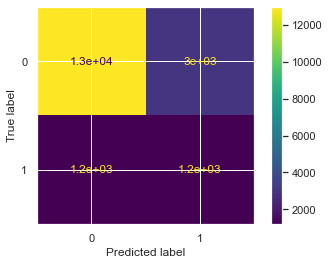

In [195]:
estimator = xgbm
plot_confusion_matrix(estimator=estimator, X=df_train[features],y_true = df_train.target)

In [175]:
# 1- getting feature importance of variables with name for XGB model
def xgb_feature_imp(model):
    """
    Gives the feature importance along with variable names for an XGB Model.
    """
    return(pd.DataFrame({'features' : model.get_booster().feature_names, 'importance' : model.feature_importances_}).\
           sort_values('importance',ascending = False))


In [176]:
feat_imp = xgb_feature_imp(model = xgbm)
feat_imp


,features,importance
7,company_size_na_ind,0.098384
10,city_event_rate,0.063962
13,company_type_rate,0.053891
58,relevent_experience=Has relevent experience,0.029428
42,enrolled_university=no_enrollment,0.026427
47,last_new_job=1,0.025362
5,major_discipline_na_ind,0.024027
14,last_new_job_rate,0.024001
33,education_level=Graduate,0.023998
12,company_size_rate,0.023821


In [177]:
estimator= xgbm
df_sub = df_test[['enrollee_id']]
df_sub['target'] = estimator.predict_proba(df_test[features])[:,1]
df_sub['target'] = estimator.predict(df_test[features])

df_sub.head()

df_sub.to_csv(f'{path}/my_submission_v5.csv',index = False)

,enrollee_id,target
0,16548,1
1,12036,0
2,11061,1
3,5032,0
4,17599,0


In [117]:
%%time
all_accuracies_data = cross_val_score(estimator=xgbm, X=df_train[features], y=df_train.target, cv=skf,\
                                      scoring = 'roc_auc',verbose = 4,n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min


Wall time: 1min 5s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [118]:
all_accuracies_data
print("Full Accuracy: %0.2f(+/- %0.2f)" % (all_accuracies_data.mean(), all_accuracies_data.std()*2))


array([0.61209909, 0.6268947 , 0.6447336 , 0.63577129, 0.61098297])

Full Accuracy: 0.63(+/- 0.03)


In [5]:
train.company_type.unique()
pd.crosstab(train.company_size, train.company_type,dropna=False)

NameError: name 'train' is not defined

In [ ]:
#enrolled_university  --  Type of University course enrolled if any
var = 'company_size'
train[var].value_counts(dropna=False)

In [ ]:
train[var].value_counts()

In [ ]:
cdi_bands,bins = pd.qcut(train.city_development_index, q = 6,retbins= True,duplicates = 'drop')
train['cdi_bands'] = cdi_bands
#train.groupby(cdi_bands).city.count()
train.groupby(cdi_bands).target.sum()/train.groupby(cdi_bands).target.count()
train.drop('cdi_bands', axis = 1,inplace=True)

In [ ]:
train.head()

In [ ]:
train.groupby('company_size').target.sum()/train.groupby('company_size').target.count()

In [ ]:
train.company_size

In [ ]:
sns.countplot(x = 'gender', hue = 'target', data = train,palette="Set1");

In [ ]:
def crosstab_2var(df,var1,var2):
    return(pd.crosstab([df[var1], df["target"]], df[var2], margins = True).style.background_gradient(cmap = "Accent"))

In [ ]:
crosstab_2var(train,'gender','company_size')

In [ ]:
train.columns

In [ ]:
sns.scatterplot(x = train.city_development_index, y = train.training_hours)

In [ ]:
sns.pairplot(train.select_dtypes('number'), hue = 'target',)
